# 7.2 bagging和pasting

前面提到，获得不同种类分类器的方法之一是使用不同的训练算法。还有另一种方法是每个预测器使用的算法相同，但是在不同的训练集随机子集上进行训练。采样时如果将样本放回，这种方法叫作bagging（bootstrap aggregating的缩写，也叫自举汇聚法）。采样时样本不放回，这种方法则叫作pasting。

bagging和pasting都允许训练实例在多个预测器中被多次使用，但是只有bagging允许训练实例被同一个预测器多次采样。

一旦预测器训练完成，集成就可以通过简单地聚合所有预测器的预测来对新实例做出预测。聚合函数通常是统计法（即最多数的预测与硬投票分类器一样）用于分类，或是平均法用于回归。每个预测器单独的偏差都高于在原始训练集上训练的偏差，但是通过聚合，同时降低了偏差和方差。**总体来说，最终结果是，与直接在原始训练集上训练的单个预测器相比，集成的偏差相近，但是方差更低。**

**你可以通过不同的CPU内核甚至不同的服务器并行地训练预测器。类似地，预测也可以并行。这正是bagging和pasting方法如此流行的原因之一，它们非常易于扩展。**

## 7.2.1 Scikit-Learn中的bagging和pasting

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")

In [3]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
len(X_train), len(X_test)

(375, 125)

In [4]:
# 这是一个bagging示例，如果想使用pasting(取样后不放回)，只需要将bootstrap=False即可
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500, max_samples=100, bootstrap=True, n_jobs=-1)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [5]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.912

**如果基本分类器可以估计类别概率（如果它具有predict_proba（）方法），则BaggingClassifier自动执行软投票而不是硬投票**

In [6]:
tree_clf = DecisionTreeClassifier()
tree_clf.fit(X_train, y_train)
y_pred = tree_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.848

In [7]:
# 绘制决策边界
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], num=100)
    x2s = np.linspace(axes[2], axes[3], num=100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

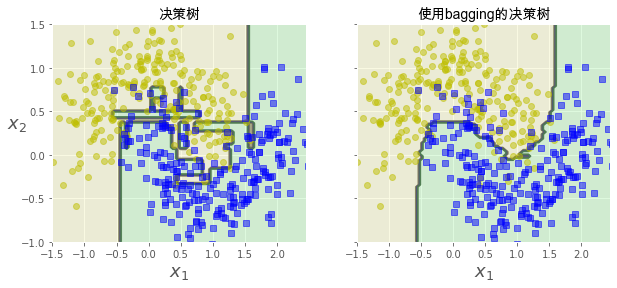

In [10]:
from matplotlib import font_manager

fontP = font_manager.FontProperties(fname="./../fonts/Arial Unicode.ttf")
# fontP.set_family('monospace')
fontP.set_size(14)

fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf, X, y)
plt.title("决策树", fontproperties=fontP)
plt.sca(axes[1])
plot_decision_boundary(bag_clf, X, y)
plt.title("使用bagging的决策树", fontproperties=fontP)
plt.ylabel("")
plt.show()

In [11]:
bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500, max_samples=100, bootstrap=True, n_jobs=-1)
bag_clf.fit(X_train, y_train)

past_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500, max_samples=100, bootstrap=False, n_jobs=-1)
past_clf.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(), bootstrap=False,
                  max_samples=100, n_estimators=500, n_jobs=-1)

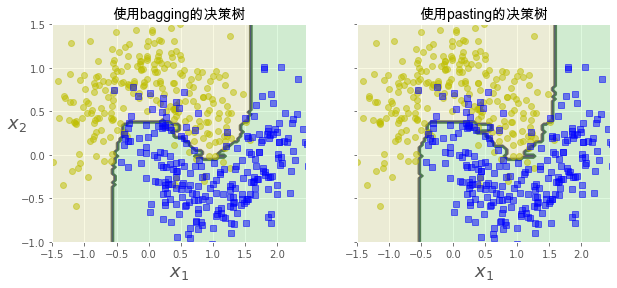

In [12]:
from matplotlib import font_manager

fontP = font_manager.FontProperties(fname="./../fonts/Arial Unicode.ttf")
# fontP.set_family('monospace')
fontP.set_size(14)

fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(bag_clf, X, y)
plt.title("使用bagging的决策树", fontproperties=fontP)
plt.sca(axes[1])
plot_decision_boundary(past_clf, X, y)
plt.title("使用pasting的决策树", fontproperties=fontP)
plt.ylabel("")
plt.show()

**由于自举法给每个预测器的训练子集引入了更高的多样性，所以最后bagging比pasting的偏差略高，但这也意味着预测器之间的关联度更低，所以集成的方差降低。总之，bagging生成的模型通常更好，这也就是为什么它更受欢迎。但是，如果你有充足的时间和CPU资源，可以使用交叉验证来对bagging和pasting的结果进行评估，再做出最合适的选择。**

## 7.2.2 包外评估

对于任意给定的预测器，使用bagging，有些实例可能会被采样多次，而有些实例则可能根本不被采样。BaggingClassifier默认采样m个训练实例，然后放回样本（bootstrap=True），m是训练集的大小。这意味着对每个预测器来说，平均只对63%的训练实例进行采样。剩余37%未被采样的训练实例称为包外（oob）实例。**注意，对所有预测器来说，这是不一样的37%。**

> 随着m的增长，该比率接近1–exp（-1）≈63.212%

由于预测器在训练过程中从未看到oob实例，因此可以在这些实例上进行评估，而无须单独的验证集。你可以通过平均每个预测器的oob评估来评估整体。

在Scikit-Learn中，创建BaggingClassifier时，设置oob_score=True就可以请求在训练结束后自动进行包外评估。

In [13]:
bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500, bootstrap=True, n_jobs=-1, oob_score=True)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.904

In [14]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, bag_clf.predict(X_test))

0.904

每个训练实例的包外决策函数也可以通过变量oob_decision_function_获得。本例中（基本预测器有predict_proba（）方法），决策函数返回的是每个实例的类别概率。

In [15]:
bag_clf.oob_decision_function_

array([[0.43333333, 0.56666667],
       [0.36781609, 0.63218391],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.04812834, 0.95187166],
       [0.33333333, 0.66666667],
       [0.01657459, 0.98342541],
       [1.        , 0.        ],
       [0.97714286, 0.02285714],
       [0.76963351, 0.23036649],
       [0.01136364, 0.98863636],
       [0.8097561 , 0.1902439 ],
       [0.87027027, 0.12972973],
       [0.96491228, 0.03508772],
       [0.05084746, 0.94915254],
       [0.        , 1.        ],
       [0.98404255, 0.01595745],
       [0.9273743 , 0.0726257 ],
       [1.        , 0.        ],
       [0.00571429, 0.99428571],
       [0.28021978, 0.71978022],
       [0.91304348, 0.08695652],
       [1.        , 0.        ],
       [0.98235294, 0.01764706],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.67213115, 0.32786885],
       [0.